In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)
import os, sys
sys.path.insert(0, r"C:\Users\Owner\time_domain_work\simphony")
from simphony.circuit import Circuit
from simphony.simulation import SampleModeSimulation,SampleModeSimulationParameters
from simphony.libraries.analytic import OpticalModulator
from simphony.libraries import siepic
from simphony.time_domain.utils import smooth_rectangular_pulse
import json
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d



In [2]:
netlist = {
    "instances":{
        "wg1":"waveguide",
        "wg2":"waveguide",
        "wg3":"waveguide",
        "wg4":"waveguide",
        "y1":"y_branch",
        "y2":"y_branch",
        "y3":"y_branch",
        "y4":"y_branch",
        "y5":"y_branch",
        "y6":"y_branch",
        "pm1":"phase_modulator1",
        "pm2":"phase_modulator2",
        "pm3":"phase_modulator3",
        "pm4":"phase_modulator4",
        "pm5":"phase_modulator5",
        "pm6":"phase_modulator6",
    },
    "connections":{
        "y1,port_2":"y2,port_1",
        "y1,port_3":"y3,port_1",

        "wg1,o0":"y2,port_2",
        "wg2,o0":"y2,port_3",

        "wg3,o0":"y3,port_2",
        "wg4,o0":"y3,port_3",

        "wg1,o1":"pm1,o0",
        "wg2,o1":"pm2,o0",
        "wg3,o1":"pm3,o0",
        "wg4,o1":"pm4,o0",

        "y4,port_2":"pm1,o1",
        "y4,port_3":"pm2,o1",
        "y5,port_2":"pm3,o1",
        "y5,port_3":"pm4,o1",

        "y6,port_2":"y4,port_1",

        "y5,port_1":"pm5,o0",
        "pm5,o1":"y6,port_3",

        "y6,port_1":"pm6,o0",
    },
    "ports":{
        "o0":"y1,port_1",
        "o1":"pm6,o1",
    }

}
T = 100e-11
dt = 1e-14
t = jnp.arange(0,T,dt)
num_measurements = 200
wvl = np.linspace(1.5, 1.6, num_measurements)


def generate_random_phases(
    key,
    t: jnp.ndarray,
    phases: jnp.ndarray,
    warmup_time: float,
    switch_time: float
) -> jnp.ndarray:
 
    dt = t[1] - t[0]
    N = t.shape[0]
    warmup_steps = int(jnp.round(warmup_time / dt))
    switch_steps = int(jnp.round(switch_time / dt))
    
    key, subkey = jax.random.split(key)
    init_phase = jax.random.choice(subkey, phases)
    
    remaining = N - warmup_steps
    num_blocks = int(jnp.ceil(remaining / switch_steps))
    
    key, subkey = jax.random.split(key)
    block_phases = jax.random.choice(subkey, phases, shape=(num_blocks,))
    
    tail = jnp.repeat(block_phases, switch_steps)[:remaining]
    
    return jnp.concatenate([
        jnp.full((warmup_steps,), init_phase),
        tail
    ])

phases = jnp.array([7*jnp.pi/8, 1.80*jnp.pi/3, jnp.pi/2.50, jnp.pi/8])


key = jax.random.PRNGKey(42)
key2 = jax.random.PRNGKey(1)

phase_array1 = generate_random_phases(
    key,
    t,
    phases,
    warmup_time=0.5e-12,
    switch_time=1e-12
)
phase_array2 = -phase_array1

phase_array3 = generate_random_phases(
    key2,
    t,
    phases,
    warmup_time=0.5e-12,
    switch_time=1e-12
)
phase_array4= -phase_array3

options = {
    'wg1': {'length': 10.0},
    'wg2': {'length': 10.0},
    'wg3': {'length': 10.0},
    'wg4': {'length': 10.0},
    
}
settings = {
    "pm1": {"mod_signal": phase_array1},
    "pm2": {"mod_signal": phase_array2},
    "pm3": {"mod_signal": phase_array3},
    "pm4": {"mod_signal": phase_array4},
    "pm5": {"mod_signal": jnp.pi/2 * jnp.ones_like(t)},
    "pm6": {"mod_signal": (-np.pi/9.3 - np.pi/2) * jnp.ones_like(t)},
}

models = {
    "waveguide":siepic.waveguide,
    "y_branch": siepic.y_branch,
    "phase_modulator1": OpticalModulator,  
    "phase_modulator2": OpticalModulator,
    "phase_modulator3": OpticalModulator,
    "phase_modulator4": OpticalModulator,
    "phase_modulator5": OpticalModulator,
    "phase_modulator6": OpticalModulator,
}
inputs = {
    'o0': smooth_rectangular_pulse(t, 0.0, T+ 20.0e-11),
    'o1': jnp.zeros_like(t),
}
c = 299792458.0
circuit = Circuit(netlist, models=models, default_settings=options)
sim = SampleModeSimulation(circuit)
sample_mode_parameters = SampleModeSimulationParameters()
tracked_ports = inputs
results = sim.run(settings = settings,tracked_ports=tracked_ports)


TypeError: OpticalModulator.__init__() got an unexpected keyword argument 'mod_signal'

In [ ]:
I = results.outputs["o1"].real
Q = results.outputs["o1"].imag
# plt.plot(t,I)
# plt.xlim(10e-11,20e-11)
# plt.show()
# plt.plot(t,Q)
# plt.xlim(10e-11,20e-11)
# plt.show()

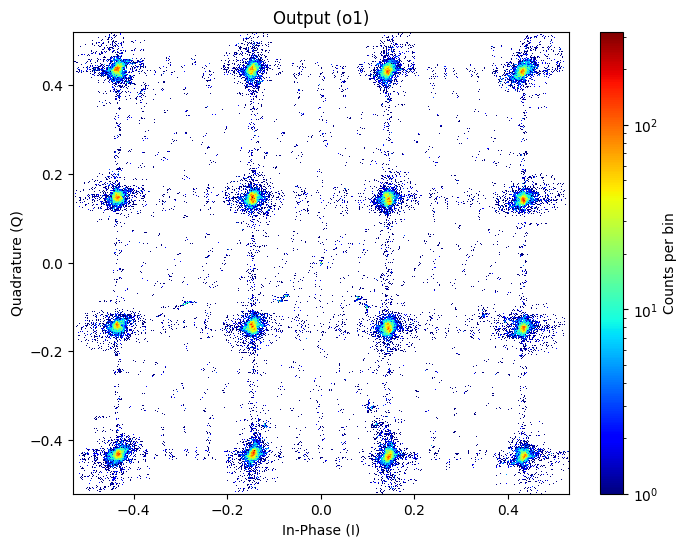

In [ ]:
import matplotlib
def upsample_trajectory(I, Q, factor=20):
    I_list, Q_list = [], []
    n = len(I)
    for i in range(n - 1):
        i0, i1 = I[i], I[i+1]
        q0, q1 = Q[i], Q[i+1]
        for alpha in np.linspace(0, 1, factor, endpoint=False):
            I_list.append(i0 + alpha*(i1 - i0))
            Q_list.append(q0 + alpha*(q1 - q0))
    # Add the last point
    I_list.append(I[-1])
    Q_list.append(Q[-1])
    return np.array(I_list), np.array(Q_list)
I = results.outputs["o1"].real
Q = results.outputs["o1"].imag
# I_out_up, Q_out_up = upsample_trajectory(I, Q, factor=10)
plt.figure(figsize=(8,6))
bins = 500
plt.hist2d( I,Q, bins=bins, cmap='jet',norm=matplotlib.colors.LogNorm() )
plt.colorbar(label="Counts per bin")
plt.title("Output (o1)")
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.show()

In [ ]:
np.savez("16QAMGen.npz", I=I, Q=Q, t=t, 
         phase_array1=phase_array1, phase_array2=phase_array2,
         phase_array3=phase_array3, phase_array4=phase_array4)